In [1]:
##%matplotlib widget
%matplotlib notebook

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jun 25 06:08:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   36C    P8    24W / 250W |      0MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name
##oldName = 'Oct11_SimpleCNN4Layer_C_100epochs_160K_lr_3em4'
##oldName = 'Oct22_SimpleCNN5Layer_C_many_epochs_160K_lr_1em4_bs64'
##oldName = 'Oct22_SimpleCNN5Layer_C_restart40epochs_240K_lr_1em4_bs64'
##oldName = 'Oct28_SimpleCNN4Layer_D_YetAnother400epochs_240K_lr_1em3_bs64'
##oldName = 'Nov11_SimpleCNN4Layer_D35_Amother200epochs_240K_lr_3em5_bs64'
##oldName = 'Nov14_SimpleCNN4Layer_D25_Another50epochs_240K_lr_3em5_bs64'
##oldName = 'Nov15_SimpleCNN4Layer_D25_Another50epochs_240K_lr_1em4_bs64_Alt_Loss_A_0p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother20epochs_240K_lr_1em4_bs64_Alt_Loss_A_2p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother250epochs_240K_lr_3em5_bs64_Alt_Loss_A_2p5'
oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0'
name = 'June24_XandXsq_CNN4Layer_D35_100epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0'


# Make an output folder named "name" (change if you want)
output = Path(name)
oldOutput = Path(oldName)
# These are the input data files to read in
trainfile = [Path('/share/lazy/schreihf/PvFinder/Aug14_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K2_train.npz')]
valfile = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.npz')

# Size of batches
batch_size = 64

# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
from model.models_mds_C import TwoFeatures_CNN4Layer_D35 as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
# Training dataset. You can put as many files here as desired.

##  set the optio load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('data/Aug14_80K_train.h5',
                            'data/Oct03_80K_train.h5',
##                          'data/Oct03_80K2_train.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True)

# Validation dataset. You can slice to reduce the size.
val_loader = collect_data('data/Oct03_20K_val.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True)

Loading data...
Loaded data/Aug14_80K_train.h5 in 13.14 s
Loaded data/Oct03_80K_train.h5 in 12.83 s
Constructing 160000 event dataset took 8.89 s
Loading data...
Loaded data/Oct03_20K_val.h5 in 3.032 s
Constructing 9984 event dataset took 0.4798 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()
loss = Loss(epsilon=1e-5,coefficient=3.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
print('oldOutput = ',oldOutput)
##model.load_state_dict(torch.load('./Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0/Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0_final.pyt'))

output =  June24_XandXsq_CNN4Layer_D35_100epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0
oldOutput =  Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0


In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


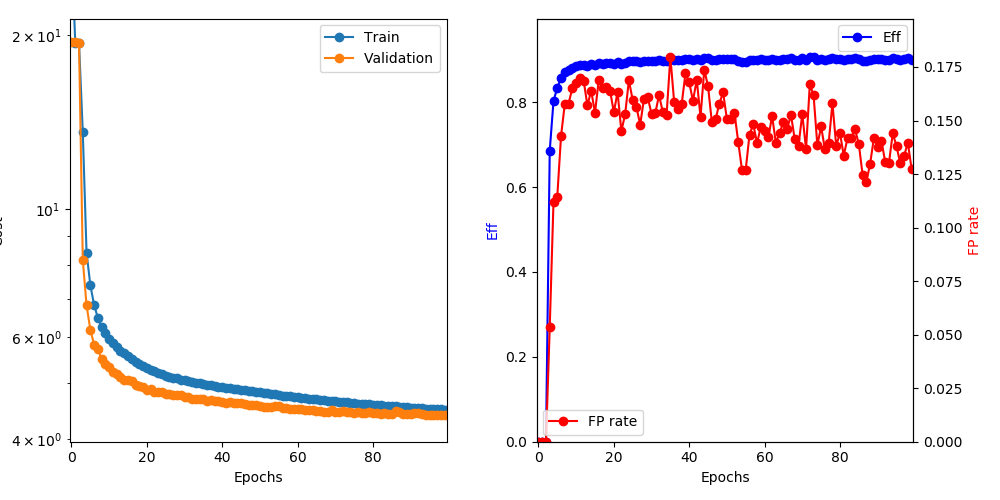

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2500, val = 156


Epoch 0: train=28.8708, val=19.4176, took 52.739 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=19.3977, val=19.4176, took 50.255 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=19.3861, val=19.3717, took 50.317 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 3: train=13.5867, val=8.17487, took 50.251 s
  Validation Found 37511 of 54700, added 535 (eff 68.58%) (0.0536 FP/event)


Epoch 4: train=8.40566, val=6.81862, took 50.336 s
  Validation Found 43925 of 54700, added 1119 (eff 80.30%) (0.112 FP/event)


Epoch 5: train=7.39409, val=6.19016, took 50.377 s
  Validation Found 45599 of 54700, added 1143 (eff 83.36%) (0.114 FP/event)


Epoch 6: train=6.8316, val=5.83354, took 50.46 s
  Validation Found 46909 of 54700, added 1426 (eff 85.76%) (0.143 FP/event)


Epoch 7: train=6.4831, val=5.72, took 50.353 s
  Validation Found 47682 of 54700, added 1576 (eff 87.17%) (0.158 FP/event)


Epoch 8: train=6.26274, val=5.50486, took 50.38 s
  Validation Found 47926 of 54700, added 1577 (eff 87.62%) (0.158 FP/event)


Epoch 9: train=6.09601, val=5.40668, took 50.371 s
  Validation Found 48211 of 54700, added 1649 (eff 88.14%) (0.165 FP/event)


Epoch 10: train=5.96625, val=5.33706, took 49.08 s
  Validation Found 48397 of 54700, added 1672 (eff 88.48%) (0.167 FP/event)


Epoch 11: train=5.86072, val=5.23208, took 50.357 s
  Validation Found 48500 of 54700, added 1696 (eff 88.67%) (0.17 FP/event)


Epoch 12: train=5.77157, val=5.18503, took 49.953 s
  Validation Found 48542 of 54700, added 1683 (eff 88.74%) (0.169 FP/event)


Epoch 13: train=5.69562, val=5.11988, took 49.353 s
  Validation Found 48490 of 54700, added 1568 (eff 88.65%) (0.157 FP/event)


Epoch 14: train=5.63123, val=5.07265, took 50.223 s
  Validation Found 48651 of 54700, added 1637 (eff 88.94%) (0.164 FP/event)


Epoch 15: train=5.56435, val=5.06138, took 50.343 s
  Validation Found 48550 of 54700, added 1533 (eff 88.76%) (0.154 FP/event)


Epoch 16: train=5.50222, val=5.05074, took 50.502 s
  Validation Found 48846 of 54700, added 1686 (eff 89.30%) (0.169 FP/event)


Epoch 17: train=5.44759, val=4.97205, took 50.48 s
  Validation Found 48713 of 54700, added 1650 (eff 89.05%) (0.165 FP/event)


Epoch 18: train=5.39931, val=4.95271, took 50.457 s
  Validation Found 48790 of 54700, added 1655 (eff 89.20%) (0.166 FP/event)


Epoch 19: train=5.34817, val=4.92305, took 50.462 s
  Validation Found 48826 of 54700, added 1637 (eff 89.26%) (0.164 FP/event)


Epoch 20: train=5.3074, val=4.86068, took 50.462 s
  Validation Found 48673 of 54700, added 1537 (eff 88.98%) (0.154 FP/event)


Epoch 21: train=5.2725, val=4.87803, took 51.137 s
  Validation Found 48946 of 54700, added 1629 (eff 89.48%) (0.163 FP/event)


Epoch 22: train=5.24, val=4.83637, took 51.221 s
  Validation Found 48693 of 54700, added 1449 (eff 89.02%) (0.145 FP/event)


Epoch 23: train=5.21049, val=4.83359, took 50.384 s
  Validation Found 48850 of 54700, added 1526 (eff 89.31%) (0.153 FP/event)


Epoch 24: train=5.18203, val=4.82509, took 50.054 s
  Validation Found 49089 of 54700, added 1686 (eff 89.74%) (0.169 FP/event)


Epoch 25: train=5.15365, val=4.79444, took 49.828 s
  Validation Found 49023 of 54700, added 1593 (eff 89.62%) (0.16 FP/event)


Epoch 26: train=5.12878, val=4.79498, took 49.282 s
  Validation Found 49009 of 54700, added 1559 (eff 89.60%) (0.156 FP/event)


Epoch 27: train=5.11265, val=4.78018, took 49.826 s
  Validation Found 48912 of 54700, added 1479 (eff 89.42%) (0.148 FP/event)


Epoch 28: train=5.0963, val=4.76405, took 49.787 s
  Validation Found 49074 of 54700, added 1598 (eff 89.71%) (0.16 FP/event)


Epoch 29: train=5.07106, val=4.76368, took 49.654 s
  Validation Found 49128 of 54700, added 1606 (eff 89.81%) (0.161 FP/event)


Epoch 30: train=5.05611, val=4.73922, took 50.306 s
  Validation Found 49013 of 54700, added 1529 (eff 89.60%) (0.153 FP/event)


Epoch 31: train=5.04172, val=4.73086, took 49.898 s
  Validation Found 49042 of 54700, added 1532 (eff 89.66%) (0.153 FP/event)


Epoch 32: train=5.02513, val=4.69308, took 50.308 s
  Validation Found 49144 of 54700, added 1616 (eff 89.84%) (0.162 FP/event)


Epoch 33: train=5.01301, val=4.68727, took 50.37 s
  Validation Found 49063 of 54700, added 1537 (eff 89.69%) (0.154 FP/event)


Epoch 34: train=4.9975, val=4.69655, took 49.159 s
  Validation Found 49077 of 54700, added 1524 (eff 89.72%) (0.153 FP/event)


Epoch 35: train=4.98175, val=4.70556, took 49.372 s
  Validation Found 49403 of 54700, added 1794 (eff 90.32%) (0.18 FP/event)


Epoch 36: train=4.97134, val=4.66517, took 50.283 s
  Validation Found 49195 of 54700, added 1586 (eff 89.94%) (0.159 FP/event)


Epoch 37: train=4.95787, val=4.68054, took 50.462 s
  Validation Found 49220 of 54700, added 1553 (eff 89.98%) (0.156 FP/event)


Epoch 38: train=4.9447, val=4.66469, took 50.38 s
  Validation Found 49190 of 54700, added 1573 (eff 89.93%) (0.158 FP/event)


Epoch 39: train=4.93355, val=4.66148, took 50.401 s
  Validation Found 49379 of 54700, added 1717 (eff 90.27%) (0.172 FP/event)


Epoch 40: train=4.92661, val=4.64282, took 50.428 s
  Validation Found 49333 of 54700, added 1676 (eff 90.19%) (0.168 FP/event)


Epoch 41: train=4.91524, val=4.6248, took 50.39 s
  Validation Found 49241 of 54700, added 1589 (eff 90.02%) (0.159 FP/event)


Epoch 42: train=4.89848, val=4.63459, took 50.419 s
  Validation Found 49367 of 54700, added 1688 (eff 90.25%) (0.169 FP/event)


Epoch 43: train=4.89172, val=4.62055, took 49.492 s
  Validation Found 49165 of 54700, added 1515 (eff 89.88%) (0.152 FP/event)


Epoch 44: train=4.88273, val=4.61373, took 50.406 s
  Validation Found 49450 of 54700, added 1735 (eff 90.40%) (0.174 FP/event)


Epoch 45: train=4.8718, val=4.61773, took 51.282 s
  Validation Found 49394 of 54700, added 1657 (eff 90.30%) (0.166 FP/event)


Epoch 46: train=4.86758, val=4.59868, took 50.39 s
  Validation Found 49172 of 54700, added 1491 (eff 89.89%) (0.149 FP/event)


Epoch 47: train=4.85212, val=4.58344, took 50.353 s
  Validation Found 49213 of 54700, added 1504 (eff 89.97%) (0.151 FP/event)


Epoch 48: train=4.84376, val=4.58266, took 50.4 s
  Validation Found 49364 of 54700, added 1577 (eff 90.24%) (0.158 FP/event)


Epoch 49: train=4.83503, val=4.58275, took 50.115 s
  Validation Found 49386 of 54700, added 1629 (eff 90.29%) (0.163 FP/event)


Epoch 50: train=4.82374, val=4.56422, took 50.138 s
  Validation Found 49320 of 54700, added 1504 (eff 90.16%) (0.151 FP/event)


Epoch 51: train=4.81344, val=4.55091, took 50.053 s
  Validation Found 49264 of 54700, added 1504 (eff 90.06%) (0.151 FP/event)


Epoch 52: train=4.80394, val=4.5502, took 51.024 s
  Validation Found 49322 of 54700, added 1534 (eff 90.17%) (0.154 FP/event)


Epoch 53: train=4.79469, val=4.54704, took 51.989 s
  Validation Found 49087 of 54700, added 1399 (eff 89.74%) (0.14 FP/event)


Epoch 54: train=4.78318, val=4.55963, took 50.957 s
  Validation Found 48943 of 54700, added 1268 (eff 89.48%) (0.127 FP/event)


Epoch 55: train=4.7708, val=4.56184, took 51.052 s
  Validation Found 48964 of 54700, added 1269 (eff 89.51%) (0.127 FP/event)


Epoch 56: train=4.76138, val=4.53506, took 51.206 s
  Validation Found 49239 of 54700, added 1432 (eff 90.02%) (0.143 FP/event)


Epoch 57: train=4.75534, val=4.52346, took 50.083 s
  Validation Found 49262 of 54700, added 1480 (eff 90.06%) (0.148 FP/event)


Epoch 58: train=4.74565, val=4.51441, took 49.465 s
  Validation Found 49147 of 54700, added 1393 (eff 89.85%) (0.14 FP/event)


Epoch 59: train=4.74334, val=4.50812, took 49.627 s
  Validation Found 49297 of 54700, added 1468 (eff 90.12%) (0.147 FP/event)


Epoch 60: train=4.73383, val=4.51991, took 49.659 s
  Validation Found 49252 of 54700, added 1449 (eff 90.04%) (0.145 FP/event)


Epoch 61: train=4.72023, val=4.51154, took 49.528 s
  Validation Found 49203 of 54700, added 1422 (eff 89.95%) (0.142 FP/event)


Epoch 62: train=4.70872, val=4.49732, took 49.613 s
  Validation Found 49385 of 54700, added 1517 (eff 90.28%) (0.152 FP/event)


Epoch 63: train=4.70189, val=4.4885, took 49.654 s
  Validation Found 49205 of 54700, added 1394 (eff 89.95%) (0.14 FP/event)


Epoch 64: train=4.69882, val=4.4898, took 49.738 s
  Validation Found 49240 of 54700, added 1441 (eff 90.02%) (0.144 FP/event)


Epoch 65: train=4.68793, val=4.47411, took 49.315 s
  Validation Found 49357 of 54700, added 1490 (eff 90.23%) (0.149 FP/event)


Epoch 66: train=4.68009, val=4.47847, took 49.543 s
  Validation Found 49292 of 54700, added 1459 (eff 90.11%) (0.146 FP/event)


Epoch 67: train=4.67136, val=4.46762, took 49.469 s
  Validation Found 49399 of 54700, added 1524 (eff 90.31%) (0.153 FP/event)


Epoch 68: train=4.66731, val=4.46792, took 49.488 s
  Validation Found 49243 of 54700, added 1410 (eff 90.02%) (0.141 FP/event)


Epoch 69: train=4.66202, val=4.48638, took 49.48 s
  Validation Found 49191 of 54700, added 1381 (eff 89.93%) (0.138 FP/event)


Epoch 70: train=4.65415, val=4.45619, took 49.482 s
  Validation Found 49441 of 54700, added 1528 (eff 90.39%) (0.153 FP/event)


Epoch 71: train=4.64762, val=4.46656, took 49.465 s
  Validation Found 49171 of 54700, added 1364 (eff 89.89%) (0.137 FP/event)


Epoch 72: train=4.63796, val=4.4699, took 49.547 s
  Validation Found 49589 of 54700, added 1667 (eff 90.66%) (0.167 FP/event)


Epoch 73: train=4.63464, val=4.46414, took 49.142 s
  Validation Found 49550 of 54700, added 1615 (eff 90.59%) (0.162 FP/event)


Epoch 74: train=4.62811, val=4.46136, took 49.361 s
  Validation Found 49248 of 54700, added 1382 (eff 90.03%) (0.138 FP/event)


Epoch 75: train=4.6198, val=4.43695, took 49.36 s
  Validation Found 49388 of 54700, added 1470 (eff 90.29%) (0.147 FP/event)


Epoch 76: train=4.6098, val=4.45981, took 49.486 s
  Validation Found 49240 of 54700, added 1364 (eff 90.02%) (0.137 FP/event)


Epoch 77: train=4.60915, val=4.44717, took 49.146 s
  Validation Found 49295 of 54700, added 1392 (eff 90.12%) (0.139 FP/event)


Epoch 78: train=4.60501, val=4.44299, took 49.749 s
  Validation Found 49499 of 54700, added 1578 (eff 90.49%) (0.158 FP/event)


Epoch 79: train=4.60081, val=4.45426, took 49.652 s
  Validation Found 49292 of 54700, added 1379 (eff 90.11%) (0.138 FP/event)


Epoch 80: train=4.59097, val=4.4403, took 49.664 s
  Validation Found 49375 of 54700, added 1440 (eff 90.27%) (0.144 FP/event)


Epoch 81: train=4.58642, val=4.44148, took 49.638 s
  Validation Found 49230 of 54700, added 1334 (eff 90.00%) (0.134 FP/event)


Epoch 82: train=4.58208, val=4.43037, took 49.755 s
  Validation Found 49340 of 54700, added 1415 (eff 90.20%) (0.142 FP/event)


Epoch 83: train=4.57486, val=4.43728, took 49.638 s
  Validation Found 49338 of 54700, added 1417 (eff 90.20%) (0.142 FP/event)


Epoch 84: train=4.57276, val=4.43118, took 49.587 s
  Validation Found 49419 of 54700, added 1456 (eff 90.35%) (0.146 FP/event)


Epoch 85: train=4.56852, val=4.42059, took 49.588 s
  Validation Found 49323 of 54700, added 1388 (eff 90.17%) (0.139 FP/event)


Epoch 86: train=4.55902, val=4.47069, took 49.625 s
  Validation Found 49097 of 54700, added 1245 (eff 89.76%) (0.125 FP/event)


Epoch 87: train=4.55729, val=4.45408, took 49.639 s
  Validation Found 49083 of 54700, added 1212 (eff 89.73%) (0.121 FP/event)


Epoch 88: train=4.54786, val=4.43033, took 49.695 s
  Validation Found 49252 of 54700, added 1296 (eff 90.04%) (0.13 FP/event)


Epoch 89: train=4.54407, val=4.42565, took 49.752 s
  Validation Found 49391 of 54700, added 1416 (eff 90.29%) (0.142 FP/event)


Epoch 90: train=4.53986, val=4.42133, took 49.659 s
  Validation Found 49319 of 54700, added 1372 (eff 90.16%) (0.137 FP/event)


Epoch 91: train=4.53825, val=4.43668, took 49.514 s
  Validation Found 49322 of 54700, added 1402 (eff 90.17%) (0.14 FP/event)


Epoch 92: train=4.53475, val=4.44513, took 49.507 s
  Validation Found 49218 of 54700, added 1305 (eff 89.98%) (0.131 FP/event)


Epoch 93: train=4.5318, val=4.43061, took 49.427 s
  Validation Found 49203 of 54700, added 1300 (eff 89.95%) (0.13 FP/event)


Epoch 94: train=4.5216, val=4.40481, took 49.653 s
  Validation Found 49428 of 54700, added 1438 (eff 90.36%) (0.144 FP/event)


Epoch 95: train=4.51916, val=4.40769, took 49.531 s
  Validation Found 49385 of 54700, added 1378 (eff 90.28%) (0.138 FP/event)


Epoch 96: train=4.51507, val=4.41432, took 49.153 s
  Validation Found 49216 of 54700, added 1298 (eff 89.97%) (0.13 FP/event)


Epoch 97: train=4.51323, val=4.40687, took 49.551 s
  Validation Found 49303 of 54700, added 1331 (eff 90.13%) (0.133 FP/event)


Epoch 98: train=4.5053, val=4.4022, took 49.971 s
  Validation Found 49431 of 54700, added 1395 (eff 90.37%) (0.14 FP/event)


Epoch 99: train=4.50163, val=4.41283, took 49.608 s
  Validation Found 49193 of 54700, added 1272 (eff 89.93%) (0.127 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
quit()